# Тестовое задание
Написать и обучить модель-автокодировщик на датасете на выбор: CIFAR10, CIFAR100.
Обучить модель-классификатор на латентных представлениях обученного автокодировщика.


### Рекомендуемые шаги для выполнения задания

**Шаг 1.** Подготовка инфраструктуры.

Создание окружения, организация структуры репозитория, загрузка датасетов.

**Шаг 2.** Реализовать модель-автоенкодер.

Выбрать архитектуру и реализовать ее совместно с процедурой обучения, подходящей для выбранного датасета.
Важно обратить внимание на выбор размерность скрытого состояния. Обосновать свой выбор.

**Шаг 3.** Обучить автоенкодер.

Нужно обучить реализованную архитектуру на скаченном датасете.
Оценить качество работы модели.

**Шаг 4.** Реализовать модель-классификатор.

Реализовать небольшую модель классификатор на скрытых представлениях уже обученного автоенкодера.
Реализовать пайплайн обучения данной модели.

**Шаг 5.** Обучение модели классификатора и визуализация результатов.

На этом шаге требуется обучить модель классификатор и оценить ее качество.
Подумайте, в каком виде было бы удобно провести демонстрацию результатов?

**Шаг 6.** Выводы и идеи.

Проведите анализ результатов, сделайте несколько выводов на основе полученных рузультатов.
Предложите свои идеи, как можно улучшить текущие результаты.


### Что будет оцениваться?
1. Реализация и оформление кода на github.
2. Соответствие решения тестовому заданию.
3. Оформление результатов.
4. Любые релевантные мысли, идеи и соображения.
5. Будет плюсом проведение нескольких экспериментов и их анализ.


---

Резюме можно отправлять на почту info@machine-intelligence.ru или через форму на [сайте](https://machine-intelligence.ru/join-us/cv).


# Подготовка датасета

Датасет CIFAR10 имеется в библиотеке torchvision. Возьмем его оттуда. Не будем разделять его train/val/test. Возьмем просто train/val, чтобы обучать автоэнкодер на максимальном числе картинок

In [1]:
from torchvision.datasets import CIFAR10
from torchvision import transforms
import torch
torch.manual_seed(0)
import random
random.seed(0)
import numpy as np
np.random.seed(0)

/home/michael/miniconda3/envs/test_task/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Аугментации подсмотрены тут: https://www.kaggle.com/code/vikasbhadoria/cifar10-high-accuracy-model-build-on-pytorch

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), 
    ])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = CIFAR10(root='CIFAR10', train=True, download=True, transform=train_transforms)
val_dataset = CIFAR10(root='CIFAR10', train=False, download=True, transform=val_transforms)

Files already downloaded and verified
Files already downloaded and verified


Class: 8


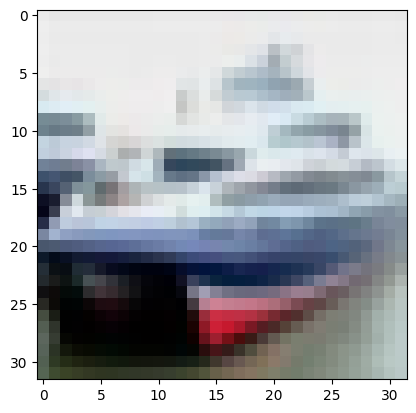

In [3]:
import matplotlib.pyplot as plt
id_to_show = 1
print('Class:', val_dataset[id_to_show][1])
plt.imshow(val_dataset[id_to_show][0].permute(1, 2, 0))

In [4]:
len(train_dataset), len(val_dataset)

(50000, 10000)

# Модель - автоэнкодер

Поскольку модель автоэнкодера состоит из энкодера и декодера, подумаем какую архитектуру можно взять. В качестве энкодера хорошо было бы взять модель, имеющую хороший скор на классификацию CIFAR10. Для этого посмотрим [тут](https://paperswithcode.com/sota/image-classification-on-cifar-10) какие модели имеют адекватное количество параметров (не вижу смысла брать огромный трансформер для такой задачи с целью увеличения скора на доли процента) и хорошие результаты. 

Хорошими кандидатами являются: DenseNet, ResNet18. Ясное дело у них есть одна основная общая черта - Residual блоки. Не будем брать эти архитектуры в чистом виде, а напишем подобную структуру самостоятельно (тем более декодер все равно писать вручную). Для этого напишем структуру одного блока, а затем соберем несколько таких в модель

Здесь видны некоторые параметры, гипотезы работы которых будут проверены далее, а именно батч-нормализация. Изначально эти параметры False

In [5]:
from torch import nn
class ResBlock(nn.Module):
    def __init__(self, c_in, c_out, k, s=1, p=1, mode='encode', use_batchnorm = False):
        self.use_batchnorm = use_batchnorm
        assert mode in ['encode', 'decode']
        super(ResBlock, self).__init__()
        if mode == 'encode':
            self.conv1 = nn.Conv2d(c_in, c_out, k, s, p)
            self.conv2 = nn.Conv2d(c_out, c_out, 3, 1, 1)
        elif mode == 'decode':
            self.conv1 = nn.ConvTranspose2d(c_in, c_out, k, s, p)
            self.conv2 = nn.ConvTranspose2d(c_out, c_out, 3, 1, 1)
        self.relu = nn.ReLU()
        self.BN_1 = nn.BatchNorm2d(c_out)
        self.BN_2 = nn.BatchNorm2d(c_out)
        self.resize = s > 1 or (s == 1 and p == 0) or c_out != c_in

    def forward(self, x):
        conv1 = self.conv1(x)
        if self.use_batchnorm:
            conv1 = self.BN_1(conv1)
        relu = self.relu(conv1)
        conv2 = self.conv2(relu)
        if self.use_batchnorm:
            conv2 = self.BN_2(conv2)
        if self.resize:
            x = self.conv1(x)
        return self.relu(x + conv2)

class Encoder(nn.Module):
    def __init__(self, use_batchnorm=False):
        super(Encoder, self).__init__()
        self.init_conv = nn.Conv2d(3, 16, 3, 1, 1) # 16 32 32
        self.rb1 = ResBlock(16, 16, 3, 2, 1, 'encode', use_batchnorm) # 16 16 16
        self.rb2 = ResBlock(16, 32, 3, 1, 1, 'encode', use_batchnorm) # 32 16 16
        self.rb3 = ResBlock(32, 32, 3, 2, 1, 'encode', use_batchnorm) # 32 8 8
        self.rb4 = ResBlock(32, 48, 3, 1, 1, 'encode', use_batchnorm) # 48 8 8
        self.rb5 = ResBlock(48, 48, 3, 2, 1, 'encode', use_batchnorm) # 48 4 4
        self.rb6 = ResBlock(48, 64, 3, 2, 1, 'encode', use_batchnorm) # 64 2 2
        self.relu = nn.ReLU()
    
    def forward(self, inputs):
        init_conv = self.relu(self.init_conv(inputs))
        rb1 = self.rb1(init_conv)
        rb2 = self.rb2(rb1)
        rb3 = self.rb3(rb2)
        rb4 = self.rb4(rb3)
        rb5 = self.rb5(rb4)
        rb6 = self.rb6(rb5)

        # outputs = {}
        # if self.save_outputs:
        #     for name, var in zip(['init_conv', 'rb1', 'rb2', 'rb3', 'rb4', 'rb5', 'rb6'], [init_conv, rb1, rb2, rb3, rb4, rb5, rb6]):
        #         outputs[name] = var.detach()
        return rb6


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.rb1 = ResBlock(64, 48, 2, 2, 0, 'decode') # 48 4 4
        self.rb2 = ResBlock(48, 48, 2, 2, 0, 'decode') # 48 8 8
        self.rb3 = ResBlock(48, 32, 3, 1, 1, 'decode') # 32 8 8
        self.rb4 = ResBlock(32, 32, 2, 2, 0, 'decode') # 32 16 16
        self.rb5 = ResBlock(32, 16, 3, 1, 1, 'decode') # 16 16 16
        self.rb6 = ResBlock(16, 16, 2, 2, 0, 'decode') # 16 32 32
        self.out_conv = nn.ConvTranspose2d(16, 3, 3, 1, 1) # 3 32 32
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, inputs):
        rb1 = self.rb1(inputs)
        rb2 = self.rb2(rb1)
        rb3 = self.rb3(rb2)
        rb4 = self.rb4(rb3)
        rb5 = self.rb5(rb4)
        rb6 = self.rb6(rb5)
        out_conv = self.out_conv(rb6)
        output = self.sigmoid(out_conv)

        # outputs = {}
        # if self.save_outputs:
        #     for name, var in zip(['rb1', 'rb2', 'rb3', 'rb4', 'rb5', 'rb6'], [rb1, rb2, rb3, rb4, rb5, rb6]):
        #         outputs[name] = var.detach()

        return output

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, use_batchnorm=False):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(use_batchnorm)
        self.decoder = Decoder()
    
    @property
    def num_params(self):
        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        num_p = sum([np.prod(p.size()) for p in model_parameters])
        return num_p
    
    def forward(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return encoded, decoded

Autoencoder().num_params

290451

In [8]:
from pytorch_lightning import LightningModule
import wandb
import PIL

class Autoencoder_Net(LightningModule):
    def __init__(self, loss_fn_name, use_batchnorm=False):
        super().__init__()

        self.sparse_loss_coef = 0
        if loss_fn_name == 'L1_loss':
            self.loss = nn.L1Loss()
        elif loss_fn_name == 'MSE_loss':
            self.loss = nn.MSELoss()
        elif loss_fn_name == 'L1_loss + Sparse':
            self.loss = nn.L1Loss()
            self.sparse_loss_coef = 0.03
        # elif loss_fn_name == 'RAE':
        #     self.rae_coef = 0.23  #from https://arxiv.org/pdf/1802.03145v1.pdf
        #     self.loss = nn.L1Loss()
        #     self.rae_loss = nn.L1Loss()

        self._model = Autoencoder(use_batchnorm)

        self.epoch_loss_values = []
        self.val_loss_values = []
        self.save_hyperparameters()
        self.best_loss = 1e9
        self.to_image = transforms.ToPILImage()

    def forward(self, x):
        return self._model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self._model.parameters(), lr=1e-3, weight_decay=1e-2
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        images, labels = batch[0], batch[1]
        encoded, output = self.forward(images)
        loss = self.loss(output, images)

        sparse_loss = 0
        if self.sparse_loss_coef > 0:
            sparse_loss += torch.mean(torch.abs(encoded))
        
        # if self.rae_coef > 0:
        #     X_T = torch.transpose(images, 2, 3)
        #     X = images
        #     X_dash_T =  torch.transpose(output, 2, 3)
        #     X_dash =  output
            
        loss = loss + self.sparse_loss_coef * sparse_loss
        return {"loss": loss}

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()    
        avg_loss = avg_loss.detach().cpu().numpy()
        self.log("train_loss", float(avg_loss))

        self.epoch_loss_values.append(avg_loss)

    def validation_step(self, batch, batch_idx):
        images, labels = batch[0], batch[1]
        encoded, output = self.forward(images)
        loss = self.loss(output, images)

        sparse_loss = 0
        if self.sparse_loss_coef > 0:
            sparse_loss += torch.mean(torch.abs(encoded))
            
        loss = loss + self.sparse_loss_coef * sparse_loss

        if batch_idx == 0:
            self.logger.log_image('val_original_images', [self.to_image(im) for im in images[:10]])
            self.logger.log_image('val_predicted_images', [self.to_image(im) for im in output[:10]])
        
        return {"loss": loss}

    def validation_epoch_end(self, outputs):

        avg_val_loss = torch.stack([x["loss"] for x in outputs]).mean()    
        avg_val_loss = avg_val_loss.detach().cpu().numpy()
        self.log("val_loss", float(avg_val_loss))

        self.val_loss_values.append(avg_val_loss)

        if avg_val_loss < self.best_loss:
            self.best_loss = avg_val_loss


In [9]:
from pytorch_lightning import LightningDataModule, Trainer
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger


class CifarDataModule(LightningDataModule):
    def __init__(self, train_dataset, val_dataset, test_dataset, batch_size, num_workers=10):
        super().__init__()
        self.num_workers = num_workers
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset
        self.batch_size = batch_size

    def setup(self, stage=None):
        pass

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )


In [11]:
from pytorch_lightning.loggers import WandbLogger

autoencoder_net = Autoencoder_Net('L1_loss')
wandb_logger = WandbLogger(log_model=True, project='MIL_test_task')
dm = CifarDataModule(train_dataset, val_dataset, val_dataset, batch_size=256)

root_dir = 'models'

trainer = Trainer(
    accelerator='gpu', 
    devices=[0],
    max_epochs=20000,
    callbacks=[
            ModelCheckpoint(
                save_weights_only=True,
                monitor="val_loss",
                mode="min",
            ),
            EarlyStopping(monitor="val_loss", mode="min", patience=15)
        ],
    default_root_dir=root_dir,
    logger=wandb_logger,
)


trainer.fit(autoencoder_net, datamodule=dm)

/home/michael/miniconda3/envs/test_task/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:396: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type        | Params
---------------------------------------
0 | _model | Autoencoder | 290 K 
1 | loss   | L1Loss      | 0     
---------------------------------------
290 K     Trainable params
0         Non-trainable params
290 K     Total params
1.162     Total estimated model params size (MB)


Epoch 256: 100%|██████████| 236/236 [00:09<00:00, 25.65it/s, loss=0.0383, v_num=e6og]


In [ ]:
autoencoder_net = Autoencoder_Net('L1_loss')
autoencoder_net = autoencoder_net.load_from_checkpoint('MIL_test_task/wz9be6og/checkpoints/epoch=241-step=47432.ckpt')

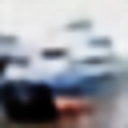

In [19]:
autoencoder_net = autoencoder_net.cpu()
autoencoder_net.eval()
to_pil_image = transforms.ToPILImage()
res, _, _= autoencoder_net(val_dataset[1][0].unsqueeze(0))
to_pil_image(res.squeeze()).resize((128, 128))

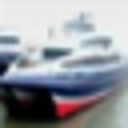

In [14]:
to_pil_image(val_dataset[1][0]).resize((128, 128))

Картинки получились немного мыльные, но так оно и должно быть (это ж не идеальное копирование). 

Больше картинок и график лосса можно найти тут: https://wandb.ai/mtyutyulnikov/MIL_test_task/runs/wz9be6og?workspace=user-mtyutyulnikov

Теперь посмотрим как у нас выглядит полученное пространство (вернее его tsne)

## Классификатор

In [20]:
wandb.finish()
autoencoder_net = Autoencoder_Net('L1_loss')
autoencoder_net = autoencoder_net.load_from_checkpoint('MIL_test_task/wz9be6og/checkpoints/epoch=241-step=47432.ckpt')
encoder_model = autoencoder_net._model.encoder 
dm = CifarDataModule(train_dataset, val_dataset, val_dataset, batch_size=256)

In [22]:
encoded_images = []
labels = []

for batch in dm.val_dataloader():
    encoded_images_batch, _ = encoder_model(batch[0])
    labels.append(batch[1])
    encoded_images.append(encoded_images_batch)

encoded_images = torch.cat(encoded_images)
labels = torch.cat(labels)

In [23]:
encoded_images = encoded_images.reshape(-1, 256).detach().numpy()
encoded_images.shape

(10000, 256)

In [24]:
from sklearn.manifold import TSNE
images_points = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(encoded_images)
images_points.shape

(10000, 2)

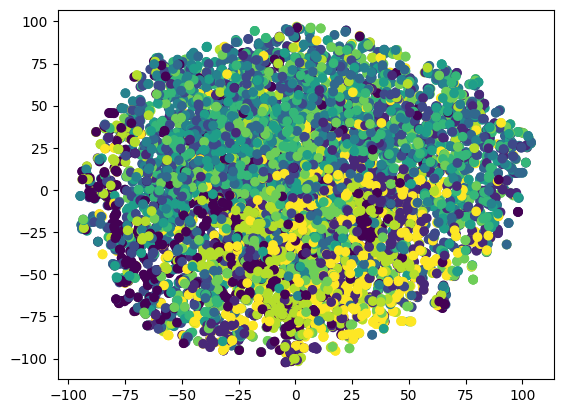

In [25]:
plt.scatter(images_points[:, 0], images_points[:, 1], c = labels)

Кажется из графика не так много информации можно увидеть (в силу большой размерности пространства). Но что-то все таки видно: желтые точки сконцентрированы внизу, а зеленые вверху, это хорошо, значит можно рассчитывать на какую-то разделимость классов. Однако линейной модели или чего то простого тут будет недостаточно - делаем персептрон. 

Дабы не усложнять себе жизнь (и поскольку моделька и так быстро учится), не будет менять датамодуль и будем обсчитывать фичи изображений каждый раз, вместо этого сделаем только другую структуру сети. 

In [9]:
from pytorch_lightning import LightningModule
import wandb
import PIL
from sklearn.metrics import classification_report, f1_score
from torchmetrics.classification import MulticlassConfusionMatrix

class Classifier_Net(LightningModule):
    def __init__(self, encoder_model, out_c):
        super().__init__()

        self.encoder_model = encoder_model

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, out_c)
        )
        
        self.loss = nn.CrossEntropyLoss()
        
        self.epoch_loss_values = []
        self.val_loss_values = []
        self.save_hyperparameters()
        self.best_loss = 1e9
        self.softmax = nn.Softmax(dim=-1)
        self.confusion_matrix = MulticlassConfusionMatrix(10, normalize='true')

    def forward(self, x):
        enc_output = self.encoder_model(x)
        return self.classifier(enc_output)

    def configure_optimizers(self):
        for param in self.encoder_model.parameters():
            param.requires_grad = False

        optimizer = torch.optim.AdamW(
            self.classifier.parameters(), lr=1e-3, weight_decay=1e-2
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        images, labels = batch[0], batch[1]
        output = self.forward(images)
        loss = self.loss(output, labels)
        preds = self.softmax(output)
        preds = torch.argmax(preds, dim=-1)

        acc = (preds == labels).float().mean()

        return {"loss": loss, 'acc' : acc}

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()    
        avg_loss = avg_loss.detach().cpu().numpy()

        avg_acc = torch.stack([x["acc"] for x in outputs]).mean()    
        avg_acc = avg_acc.detach().cpu().numpy()

        self.log("train_loss", float(avg_loss))
        self.log("train_acc", float(avg_acc))

        self.epoch_loss_values.append(avg_loss)

    def validation_step(self, batch, batch_idx):
        images, labels = batch[0], batch[1]
        output = self.forward(images)
        loss = self.loss(output, labels)

        preds = self.softmax(output)
        preds = torch.argmax(preds, dim=-1)
        acc = (preds == labels).float().mean()
        return {"loss": loss, 'acc': acc}

    def validation_epoch_end(self, outputs):
        avg_val_loss = torch.stack([x["loss"] for x in outputs]).mean()    
        avg_val_loss = avg_val_loss.detach().cpu().numpy()
        self.log("val_loss", float(avg_val_loss))

        avg_val_acc = torch.stack([x["acc"] for x in outputs]).mean()    
        avg_val_acc = avg_val_acc.detach().cpu().numpy()
        self.log("val_acc", float(avg_val_acc))

        self.val_loss_values.append(avg_val_loss)

        if avg_val_loss < self.best_loss:
            self.best_loss = avg_val_loss

    def predict_step(self, batch, batch_idx):
        images, labels = batch[0], batch[1]
        output = self.forward(images)
        preds = self.softmax(output)
        preds = torch.argmax(preds, dim=-1)
        return preds


In [27]:

classifier_net = Classifier_Net(encoder_model, 10)
wandb_logger = WandbLogger(log_model=True, project='MIL_test_task_classifier')
dm = CifarDataModule(train_dataset, val_dataset, val_dataset, batch_size=512)

root_dir = 'models_classifier'

trainer = Trainer(
    accelerator='gpu', 
    devices=[0],
    max_epochs=20000,
    callbacks=[
            ModelCheckpoint(
                save_weights_only=True,
                monitor="val_loss",
                mode="min",
            ),
            EarlyStopping(monitor="val_loss", mode="min", patience=15)
        ],
    default_root_dir=root_dir,
    logger=wandb_logger,
)

trainer.fit(classifier_net, datamodule=dm)

/home/michael/miniconda3/envs/test_task/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
  rank_zero_warn(


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | encoder_model | Encoder          | 179 K 
1 | classifier    | Sequential       | 43.6 K
2 | loss          | CrossEntropyLoss | 0     
3 | softmax       | Softmax          | 0     
---------------------------------------------------
43.6 K    Trainable params
179 K     Non-trainable params
222 K     Total params
0.891     Total estimated model params size (MB)


Epoch 137:  76%|███████▋  | 90/118 [00:04<00:01, 19.08it/s, loss=1.27, v_num=dgoy] 

/home/michael/miniconda3/envs/test_task/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


/home/michael/miniconda3/envs/test_task/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 70.37it/s] 
Acc : tensor(0.5451)


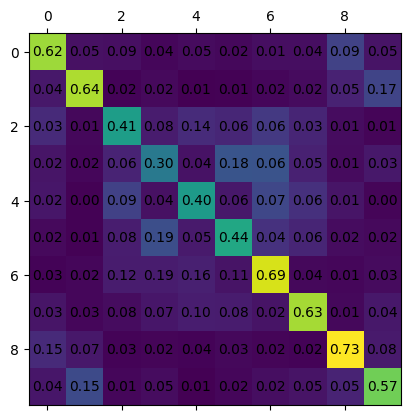

In [44]:
from torchmetrics.functional.classification import multiclass_confusion_matrix

classifier_net = Classifier_Net(encoder_model, 10)
classifier_net = classifier_net.load_from_checkpoint('MIL_test_task_classifier/fudddgoy/checkpoints/epoch=125-step=12348.ckpt')

labels = torch.tensor(val_dataset.targets)

preds = trainer.predict(classifier_net, dm.val_dataloader())
preds = torch.cat(preds)

acc = (preds == labels).float().mean()
print('Acc :', acc)

conf_matrix = multiclass_confusion_matrix(preds, labels, 10, normalize='true')

plt.matshow(conf_matrix)

for (x, y), value in np.ndenumerate(conf_matrix):
    plt.text(x, y, f"{value:.2f}", va="center", ha="center")

Итак, какие результаты получились?

https://wandb.ai/mtyutyulnikov/MIL_test_task_classifier/runs/sog3btwe?workspace=user-mtyutyulnikov

Точность на валиде составила 54,5%. Из Confusion матрицы видно, что 6 классов классифицируются относительно хорошо (больше чем 0.5), еще 4 класса плохо (ниже 0.5). Каких то явных выбросов в точности нету, значит надо улучшать фичер-экстракцию. Да и в классификаторе ничего особо больше не придумаешь

## Другой лосс (MSE Loss)

In [11]:
# wandb.finish()
autoencoder_net = Autoencoder_Net('MSE_loss')
wandb_logger = WandbLogger(log_model=True, project='MIL_test_task')
dm = CifarDataModule(train_dataset, val_dataset, val_dataset, batch_size=512)

root_dir = 'models'

trainer = Trainer(
    accelerator='gpu', 
    devices=[0],
    max_epochs=20000,
    callbacks=[
            ModelCheckpoint(
                save_weights_only=True,
                monitor="val_loss",
                mode="min",
            ),
            EarlyStopping(monitor="val_loss", mode="min", patience=10)
        ],
    default_root_dir=root_dir,
    logger=wandb_logger,
)


trainer.fit(autoencoder_net, datamodule=dm)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mtyutyulnikov. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type        | Params
---------------------------------------
0 | _model | Autoencoder | 290 K 
1 | loss   | MSELoss     | 0     
---------------------------------------
290 K     Trainable params
0         Non-trainable params
290 K     Total params
1.162     Total estimated model params size (MB)


Epoch 236: 100%|██████████| 118/118 [00:07<00:00, 16.55it/s, loss=0.00397, v_num=ui44]


In [12]:
autoencoder_net = Autoencoder_Net('MSE_loss')
autoencoder_net = autoencoder_net.load_from_checkpoint('MIL_test_task/a3c3ui44/checkpoints/epoch=226-step=22246.ckpt')
encoder_model = autoencoder_net._model.encoder

Кажется [изображения](https://wandb.ai/mtyutyulnikov/MIL_test_task/runs/a3c3ui44?workspace=user-mtyutyulnikov) стали четче, стали видны некоторые детали объектов (лягушка четче). Из этого можно предположить, что можно получить лучше результаты на классификации

In [14]:
classifier_net = Classifier_Net(encoder_model, 10)
wandb_logger = WandbLogger(log_model=True, project='MIL_test_task_classifier')
dm = CifarDataModule(train_dataset, val_dataset, val_dataset, batch_size=512)

root_dir = 'models_classifier'

trainer = Trainer(
    accelerator='gpu', 
    devices=[0],
    max_epochs=20000,
    callbacks=[
            ModelCheckpoint(
                save_weights_only=True,
                monitor="val_loss",
                mode="min",
            ),
            EarlyStopping(monitor="val_loss", mode="min", patience=15)
        ],
    default_root_dir=root_dir,
    logger=wandb_logger,
)

trainer.fit(classifier_net, datamodule=dm)

/home/michael/miniconda3/envs/test_task/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
  rank_zero_warn(


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params
---------------------------------------------------------------
0 | encoder_model    | Encoder                   | 179 K 
1 | classifier       | Sequential                | 43.6 K
2 | loss             | CrossEntropyLoss          | 0     
3 | softmax          | Softmax                   | 0     
4 | confusion_matrix | MulticlassConfusionMatrix | 0     
---------------------------------------------------------------
43.6 K    Trainable params
179 K     Non-trainable params
222 K     Total params
0.891     Total estimated model params size (MB)


Epoch 155:  25%|██▌       | 30/118 [00:01<00:05, 15.17it/s, loss=1.31, v_num=90ow] 

/home/michael/miniconda3/envs/test_task/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


/home/michael/miniconda3/envs/test_task/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 68.62it/s] 
Acc : tensor(0.5350)


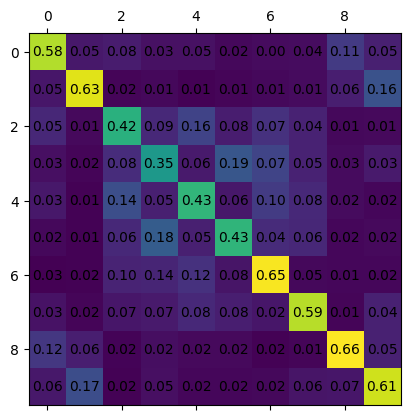

In [15]:
from torchmetrics.functional.classification import multiclass_confusion_matrix

classifier_net = Classifier_Net(encoder_model, 10)
classifier_net = classifier_net.load_from_checkpoint('MIL_test_task_classifier/xgjv90ow/checkpoints/epoch=150-step=14798.ckpt')

labels = torch.tensor(val_dataset.targets)

preds = trainer.predict(classifier_net, dm.val_dataloader())
preds = torch.cat(preds)

acc = (preds == labels).float().mean()
print('Acc :', acc)

conf_matrix = multiclass_confusion_matrix(preds, labels, 10, normalize='true')

plt.matshow(conf_matrix)

for (x, y), value in np.ndenumerate(conf_matrix):
    plt.text(x, y, f"{value:.2f}", va="center", ha="center")

Грустно и печально. Несмотря на повышение четкости изображений, точность у нас не увеличилась, а даже немного [ухудшилась](https://wandb.ai/mtyutyulnikov/MIL_test_task_classifier/runs/me3pov9s). Давайте думать как можно поменять архитектуру автоэнкодера

## L1-Loss + BatchNorm2D

In [10]:
autoencoder_net = Autoencoder_Net('L1_loss', use_batchnorm=True)
wandb_logger = WandbLogger(log_model=True, project='MIL_test_task')
dm = CifarDataModule(train_dataset, val_dataset, val_dataset, batch_size=512)

root_dir = 'models'

trainer = Trainer(
    accelerator='gpu', 
    devices=[0],
    max_epochs=20000,
    callbacks=[
            ModelCheckpoint(
                save_weights_only=True,
                monitor="val_loss",
                mode="min",
            ),
            EarlyStopping(monitor="val_loss", mode="min", patience=10)
        ],
    default_root_dir=root_dir,
    logger=wandb_logger,
)


trainer.fit(autoencoder_net, datamodule=dm)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mtyutyulnikov. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type        | Params
---------------------------------------
0 | loss   | L1Loss      | 0     
1 | _model | Autoencoder | 290 K 
---------------------------------------
290 K     Trainable params
0         Non-trainable params
290 K     Total params
1.162     Total estimated model params size (MB)


Epoch 145: 100%|██████████| 118/118 [00:07<00:00, 16.03it/s, loss=0.0437, v_num=ngm2]


In [13]:
autoencoder_net = Autoencoder_Net('L1_loss', use_batchnorm=True)
autoencoder_net = autoencoder_net.load_from_checkpoint('MIL_test_task/uovmngm2/checkpoints/epoch=135-step=13328.ckpt')
encoder_model = autoencoder_net._model.encoder

In [14]:
classifier_net = Classifier_Net(encoder_model, 10)
wandb_logger = WandbLogger(log_model=True, project='MIL_test_task_classifier')
dm = CifarDataModule(train_dataset, val_dataset, val_dataset, batch_size=512)

root_dir = 'models_classifier'

trainer = Trainer(
    accelerator='gpu', 
    devices=[0],
    max_epochs=20000,
    callbacks=[
            ModelCheckpoint(
                save_weights_only=True,
                monitor="val_loss",
                mode="min",
            ),
            EarlyStopping(monitor="val_loss", mode="min", patience=50)
        ],
    default_root_dir=root_dir,
    logger=wandb_logger,
)

trainer.fit(classifier_net, datamodule=dm)

/home/michael/miniconda3/envs/test_task/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
  rank_zero_warn(


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params
---------------------------------------------------------------
0 | encoder_model    | Encoder                   | 179 K 
1 | classifier       | Sequential                | 43.6 K
2 | loss             | CrossEntropyLoss          | 0     
3 | softmax          | Softmax                   | 0     
4 | confusion_matrix | MulticlassConfusionMatrix | 0     
---------------------------------------------------------------
43.6 K    Trainable params
179 K     Non-trainable params
222 K     Total params
0.891     Total estimated model params size (MB)


Epoch 186:   0%|          | 0/118 [00:00<?, ?it/s, loss=1.24, v_num=plaa]          

/home/michael/miniconda3/envs/test_task/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Опять в [результатах](https://wandb.ai/mtyutyulnikov/MIL_test_task_classifier/runs/758je0v0?workspace=user-mtyutyulnikov) - ничего нового. Точность на валиде - 48%

# L1-loss + Sparse L1 

Почитав статьи в интернете (например эту [обзорную статью](https://arxiv.org/pdf/2003.05991.pdf)), стало понятно, что можно использовать регуляризации при обучении. Будем хранить выходы со всех блоков сети и добавлять их среднюю величину к нашему лоссу (формула 2 в статье).



In [10]:
autoencoder_net = Autoencoder_Net('L1_loss + Sparse', use_batchnorm=True)
wandb_logger = WandbLogger(log_model=True, project='MIL_test_task')
dm = CifarDataModule(train_dataset, val_dataset, val_dataset, batch_size=512)

root_dir = 'models'
trainer = Trainer(
    accelerator='gpu', 
    devices=[0],
    max_epochs=20000,
    callbacks=[
            ModelCheckpoint(
                save_weights_only=True,
                monitor="val_loss",
                mode="min",
            ),
            EarlyStopping(monitor="val_loss", mode="min", patience=30)
        ],
    default_root_dir=root_dir,
    logger=wandb_logger,
)


trainer.fit(autoencoder_net, datamodule=dm)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mtyutyulnikov. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type        | Params
---------------------------------------
0 | loss   | MSELoss     | 0     
1 | _model | Autoencoder | 290 K 
---------------------------------------
290 K     Trainable params
0         Non-trainable params
290 K     Total params
1.162     Total estimated model params size (MB)


Epoch 109:  15%|█▌        | 18/118 [00:01<00:10,  9.27it/s, loss=0.00746, v_num=83kj] 

/home/michael/miniconda3/envs/test_task/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Проведено 2 эксперимента:

1. Со значением sparsity_coef = 0.15 (https://wandb.ai/mtyutyulnikov/MIL_test_task/runs/dd7nm8n0?workspace=user-mtyutyulnikov), лосс не падал
2. Со значением sparsity_coef = 0.03 (https://wandb.ai/mtyutyulnikov/MIL_test_task/runs/0qtofyg0?workspace=user-mtyutyulnikov), лосс вышел на плато и тоже не падал

Итог - плохие изображения, пробовать обучать классификатор не будем.

# Выводы
Итого получилось добиться наибольшей точности при использовании одного лишь L1-лосса: 54.5%.

Полученная точность на классификации показывает, что автоэнкодер недостаточно хорошо вытягивает фичи из изображений. 

Как можно улучшить модель?

- Использовать регуляризацию из статьи https://arxiv.org/abs/1802.03145v1. В ней рассматривают способ, учитывающий не только сами изображения на входе и выходе автоэнкодера, но и их отношение между собой (произведение матриц).  На CIFAR-10 получаются результаты лучше, чем без

- Поиграться с размерностью латентного пространства. Мой выбор 256 обоснован интуицией и "пальцем в небо" (ну точнее посчитал, что тензор изображения 32х32х3 = 3072, значит раз было бы неплохо взять раз в 10 меньше размерность). Если взять больше, то есть риск, что автоэнкодер начнет просто повторять изображения, не вытягивая фичи. Если меньше - то фичей станет меньше, точность упадет еще меньше.
 
- Попробовать использовать для Sparse Autoencoder-модели KL-дивергенцию, а не L1. Однако, если L1 не дало видимых результатов, то и тут ожидать чего-то не стоит.

- Усложнять архитектуру модели автоэнкодера. Взять модель на 1-3М параметров (например, DenseNet, имеющий хороший скор на классификацию CIFAR10). Можно использовать его только в качестве энкодера или написать Densenet-подобный декодер. 

- Ансамблирование нескольких автоэнкодеров

- Использование вариационного автоэнкодера (использующего случайные величины вместо весов). Хоть эта штука больше предназначена для GAN-ов, тут она может дать подсказку какую размерность пространства лучше взять